<a href="https://colab.research.google.com/github/tiaL-ops/Data-MLProject/blob/main/CaloriesCounter_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calorie Counter: Exploring Object Detection with MediaPipe

Welcome to the Calorie Counter project, where I delve into the exciting world of object detection using Google's powerful [MediaPipe object detection model](https://developers.google.com/mediapipe/solutions/vision/object_detector#models).

In this project, I take this cutting-edge model and harness it for a unique purpose – detecting food items and tallying up their calorie counts. My journey goes beyond just showcasing its capabilities; I also take a close look at its limitations and envision potential future developments.

**Disclaimer:** This notebook serves as a stepping stone for educational purposes, offering a basic approach to familiarize myself with object detection techniques. 😄

## Preparation

Let's start with installing MediaPipe.

In [ ]:
!pip install -q mediapipe==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 54.4 MB/s eta 0:00:00


Then download an off-the-shelf model. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/object_detector#models) for more image classification models that you can use.

In [ ]:
!wget -q -O efficientdet.tflite -q https://storage.googleapis.com/mediapipe-models/object_detector/efficientdet_lite0/int8/1/efficientdet_lite0.tflite

In [ ]:
#EfficientDet-Lite0 (float 32)

## Visualization utilities

In [ ]:
#@markdown We implemented some functions to visualize the object detection results. <br/> Run the following cell to activate the functions.
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

Let's get our picture from drive

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build

# Authenticate with Google Drive API
auth.authenticate_user()
drive_service = build('drive', 'v3')

# Replace 'YOUR_FOLDER_ID' with the actual folder ID
folder_id = '1g_CMk6sFgjEfkS7yvAEuYAqKDa_C4CZI'

# Retrieve folder contents by ID
folder_contents = drive_service.files().list(q=f"'{folder_id}' in parents", fields="files(name, id)").execute()
files = folder_contents.get('files', [])

if files:
    print(f"Contents of the folder with ID '{folder_id}':")
    for file in files:
        print(f"File Name: {file['name']}, File ID: {file['id']}")
else:
    print(f"No files found in the folder with ID '{folder_id}'.")

#https://drive.google.com/drive/folders/1g_CMk6sFgjEfkS7yvAEuYAqKDa_C4CZI?usp=sharing

Contents of the folder with ID '1g_CMk6sFgjEfkS7yvAEuYAqKDa_C4CZI':
File Name: sandwich.png, File ID: 1bdcA_ABMP7fXh1MfMifQMvoB2FS93seM
File Name: donut.png, File ID: 1ZefDOolwnzmqTN3Ivf5sBjvAmFgFxsaN
File Name: apple&banana.png, File ID: 1aE4dvIvAPIHh6EJkgqI_3W2hrO07mO8N
File Name: .DS_Store, File ID: 13V-nraADuvcODfbToOy0THPuvlDQwZRn


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the file or folder ID (replace with your own)
appleB= "1aE4dvIvAPIHh6EJkgqI_3W2hrO07mO8N"
donut="1ZefDOolwnzmqTN3Ivf5sBjvAmFgFxsaN"
sand="1bdcA_ABMP7fXh1MfMifQMvoB2FS93seM"



# Download the file or folder
!gdown --id {appleB}
!gdown --id {donut}
!gdown --id {sand}

# Move the downloaded file or folder to the 'content' directory
!mv {appleB} /content/
!mv {donut} /content/
!mv {sand} /content/


Mounted at /content/drive
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aE4dvIvAPIHh6EJkgqI_3W2hrO07mO8N
To: /content/apple&banana.png
100% 761k/761k [00:00<00:00, 129MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZefDOolwnzmqTN3Ivf5sBjvAmFgFxsaN
To: /content/donut.png
100% 1.35M/1.35M [00:00<00:00, 110MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: ht

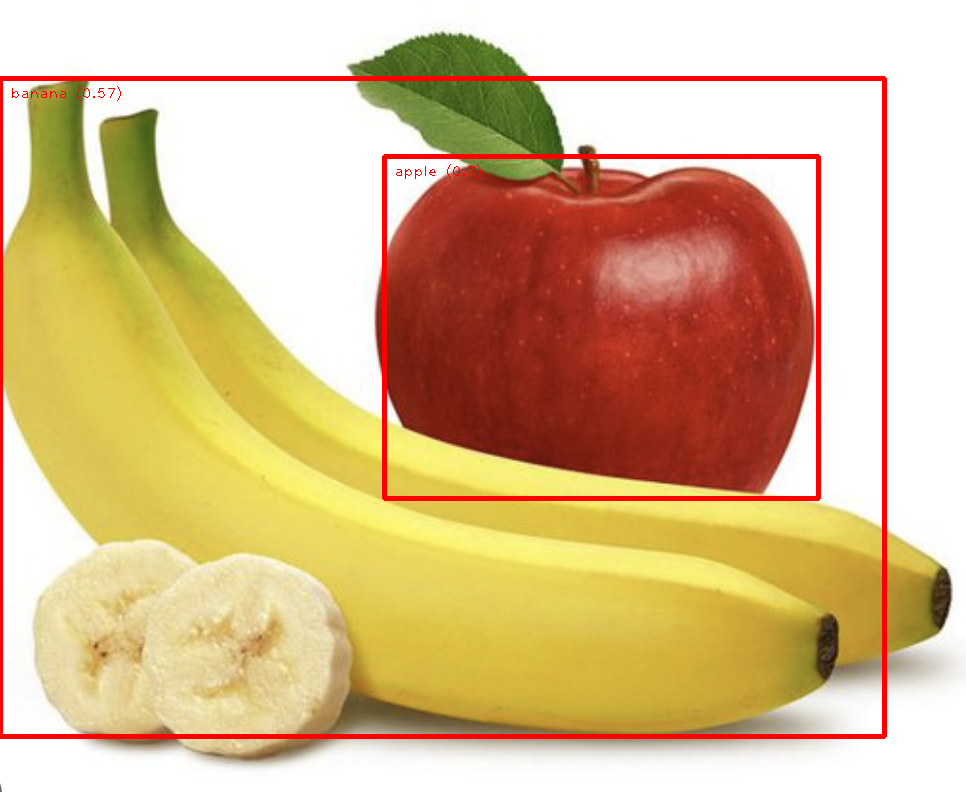

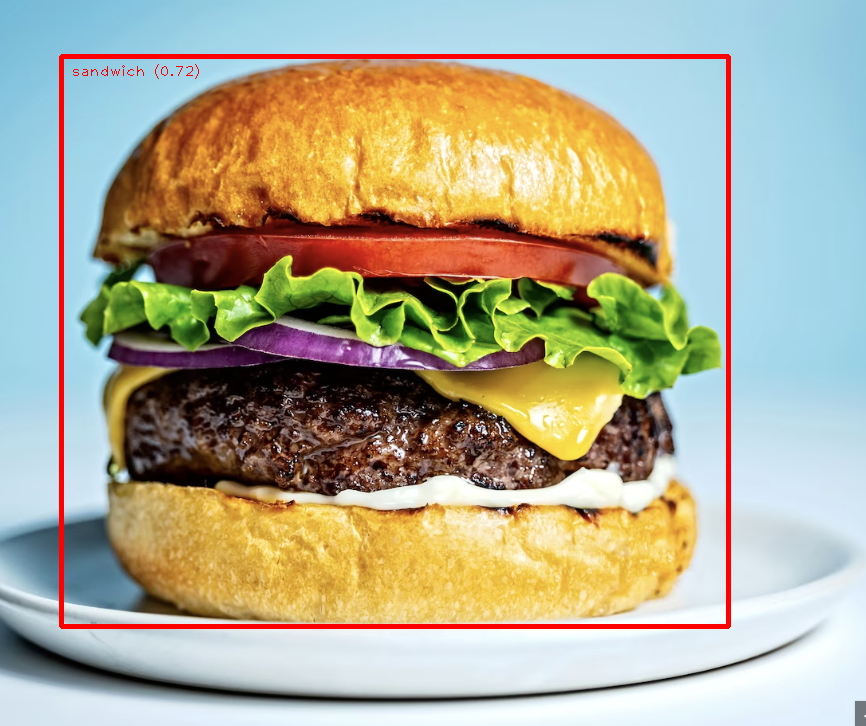

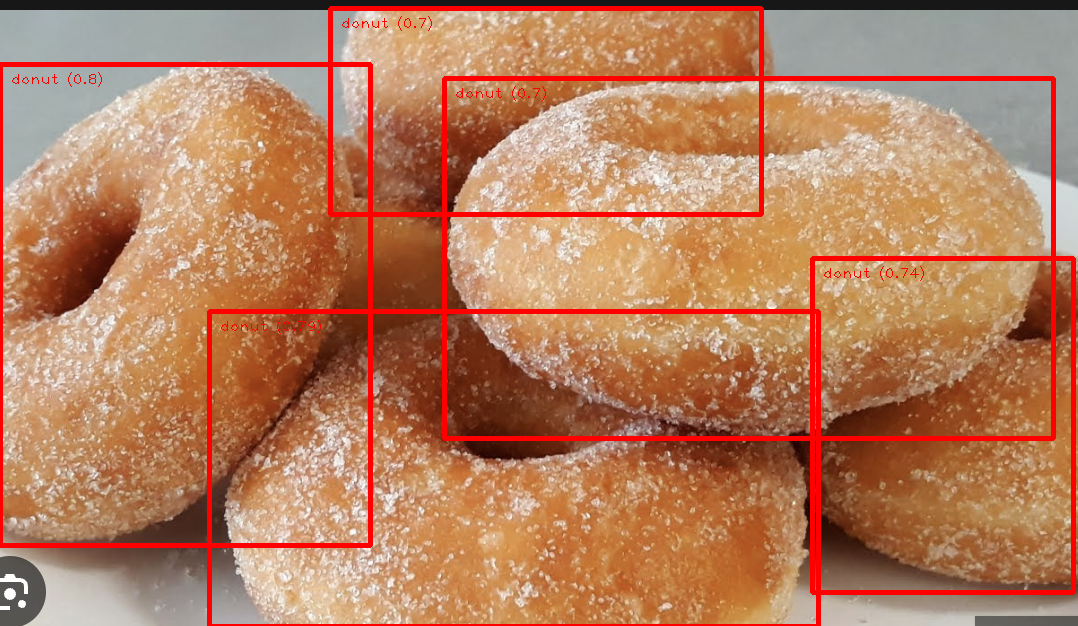

In [ ]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import cv2
from google.colab.patches import cv2_imshow

# STEP 2: Create an ObjectDetector object.
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

# Define a list of image filenames to process.
image_filenames = ['apple&banana.png', 'sandwich.png', 'donut.png']

# STEP 3: Process each image.
for image_filename in image_filenames:
    # Load the input image.
    image = mp.Image.create_from_file(image_filename)

    # Detect objects in the input image.
    detection_result = detector.detect(image)

    # STEP 5: Process the detection result. In this case, visualize it.
    image_copy = np.copy(image.numpy_view())
    annotated_image = visualize(image_copy, detection_result)
    rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    cv2_imshow(rgb_annotated_image)


Now we can play around with it, I decided to get the text and add some knowlege of calories I have seen on GOogle.

In [ ]:

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

image_filenames = ['apple&banana.png', 'sandwich.png', 'donut.png']

for image_filename in image_filenames:

    image = mp.Image.create_from_file(image_filename)

    detection_result = detector.detect(image)

    print(f"Detected objects in {image_filename}:")

    for detection in detection_result.detections:
        category = detection.categories[0]
        category_name = category.category_name
        probability = round(category.score, 2)
        print(f"- Object: {category_name}, Probability: {probability}")

    print("\n")


Detected objects in apple&banana.png:
- Object: apple, Probability: 0.7
- Object: banana, Probability: 0.57


Detected objects in sandwich.png:
- Object: sandwich, Probability: 0.72


Detected objects in donut.png:
- Object: donut, Probability: 0.8
- Object: donut, Probability: 0.79
- Object: donut, Probability: 0.74
- Object: donut, Probability: 0.7
- Object: donut, Probability: 0.7




In [ ]:
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options, score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)


image_filenames = ['apple&banana.png', 'sandwich.png', 'donut.png']


calorie_values = {
    'banana': 100,
    'apple': 55,
    'donut': 500,
    'sandwich': 1000
}


for image_filename in image_filenames:

    image = mp.Image.create_from_file(image_filename)


    detection_result = detector.detect(image)

    print(f"Detected objects in {image_filename}:")
    total_calories = 0

    for detection in detection_result.detections:
        category = detection.categories[0]
        category_name = category.category_name.lower()
        probability = round(category.score, 2)

        if category_name in calorie_values:
            calories = calorie_values[category_name]
            total_calories += (calories * probability)
            print(f"- Object: {category_name.capitalize()}, Probability: {probability}, Calories: {calories}")
        else:
            print(f"- Object: {category_name.capitalize()} (Unknown), Probability: {probability}")

    print(f"Total Calories in {image_filename}: {total_calories} calories\n")


Detected objects in apple&banana.png:
- Object: Apple, Probability: 0.7, Calories: 55
- Object: Banana, Probability: 0.57, Calories: 100
Total Calories in apple&banana.png: 95.5 calories

Detected objects in sandwich.png:
- Object: Sandwich, Probability: 0.72, Calories: 1000
Total Calories in sandwich.png: 720.0 calories

Detected objects in donut.png:
- Object: Donut, Probability: 0.8, Calories: 500
- Object: Donut, Probability: 0.79, Calories: 500
- Object: Donut, Probability: 0.74, Calories: 500
- Object: Donut, Probability: 0.7, Calories: 500
- Object: Donut, Probability: 0.7, Calories: 500
Total Calories in donut.png: 1865.0 calories



**FUTURE PROJECT PLAN:**

As I mentioned earlier, this project is primarily educational in nature. Looking ahead to future endeavors, it is evident that it holds substantial promise.
The significance of promoting healthy eating extends beyond a mere trend; it has transcended into a lifestyle choice desired by many. The practical integration of these principles into our daily routines has the potential to significantly enhance the quality of our lives.

A plan would be to being ble to detect every type of food, the model I used is fairly weak and only can detect most of what I used.
